In [11]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.append('/home/cocoza4/workspace/absorouteio/asr-face-recognition/src')

import os
import csv
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from pathlib import Path
from tqdm.auto import tqdm
from scipy import interpolate

import matplotlib.pyplot as plt

import utils

tf.__version__

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


'2.1.0'

In [2]:
ff_path = Path('/home/cocoza4/datasets/cfp_front_mtcnn_margin32')
fp_path = Path('/home/cocoza4/datasets/cfp_profile')

model_path = Path('/home/cocoza4/workspace/facenet/models/facenet/VGGFace2/20180402-114759')

In [12]:
def load_graph(modle_file):
    graph = tf.Graph()
    with graph.as_default():
        graph_def = tf.compat.v1.GraphDef()
        with tf.io.gfile.GFile(str(modle_file), 'rb') as fid:
            serialized_graph = fid.read()
            graph_def.ParseFromString(serialized_graph)
            tf.import_graph_def(graph_def, name='')

    return graph

def preprocess(files):
    images = []
    for file in files:
        resized = Image.open(file).resize((160, 160))
        img = np.asarray(resized)
        if img.ndim == 2:
            print(file, img.shape)
            img = utils.to_rgb(img)
        img = (img - 127.5) / 128.
        images.append(img)
    return np.array(images)

def inference(sess, inputs):
    feed_dict = {images_placeholder: inputs, 'phase_train:0': False}
    return sess.run(embeddings, feed_dict=feed_dict)

In [4]:
embedding_size = 512
batch_size = 64

In [5]:
img_file = '/home/cocoza4/datasets/cfp_front_mtcnn_margin32/001/01.png'
img = np.asarray(Image.open(img_file).resize((160, 160)))
img.shape

(160, 160, 3)

In [6]:
graph = load_graph(model_path/'20180402-114759.pb')
images_placeholder = graph.get_tensor_by_name("input:0")
embeddings = graph.get_tensor_by_name("embeddings:0")

In [7]:
sess = tf.compat.v1.Session(graph=graph)

In [8]:
X_sample = preprocess([img_file])
emb = inference(sess, X_sample)
emb

array([[ 7.05738440e-02, -2.48117582e-03, -7.03147845e-03,
        -3.12255938e-02, -7.15363249e-02, -5.69844507e-02,
        -4.98510487e-02, -1.31327463e-02,  5.43050505e-02,
        -1.13506965e-01, -2.51275692e-02, -2.63893846e-02,
         1.99282523e-02, -4.13102210e-02, -7.31099863e-03,
        -1.65218711e-02,  4.63890769e-02, -1.33911632e-02,
        -3.33237760e-02, -2.83627845e-02,  2.32691667e-03,
        -5.19025102e-02,  3.28694694e-02,  3.63047197e-02,
        -2.82503720e-02,  4.70629297e-02, -3.05005927e-02,
        -1.42018648e-03,  4.48592789e-02,  6.15581945e-02,
         2.11698730e-02,  3.24277654e-02, -3.27140186e-03,
        -5.69126792e-02, -7.23220268e-03,  3.85919549e-02,
        -7.35965520e-02,  9.69581027e-03, -5.04008532e-02,
         6.04889691e-02,  1.00137116e-02, -3.84257436e-02,
        -3.11580971e-02, -6.52833143e-03,  5.20800706e-03,
        -4.32015508e-02, -4.23978232e-02,  7.38090128e-02,
        -7.30187073e-02,  2.74887821e-03, -1.49351964e-0

In [9]:
def predict_embeddings(paths, fold):
    n_images = len(paths)
    embs_array = np.zeros((n_images, embedding_size))
    it = tqdm(range(0, n_images, batch_size), 'Fold {}'.format(fold))
    for start in it:
        end = start + batch_size
        batch = preprocess(paths[start:end])
        embs_array[start:end] = inference(sess, batch)
        
    return embs_array

def calculate_accuracy(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    tp = np.sum(np.logical_and(predict_issame, actual_issame))
    fp = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    tn = np.sum(np.logical_and(np.logical_not(predict_issame), np.logical_not(actual_issame)))
    fn = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
  
    tpr = 0 if (tp+fn==0) else float(tp) / float(tp+fn)
    fpr = 0 if (fp+tn==0) else float(fp) / float(fp+tn)
    acc = float(tp+tn)/dist.size
    return tpr, fpr, acc

def calculate_val_far_frr(threshold, dist, actual_issame):
    predict_issame = np.less(dist, threshold)
    true_accept = np.sum(np.logical_and(predict_issame, actual_issame))
    false_accept = np.sum(np.logical_and(predict_issame, np.logical_not(actual_issame)))
    false_reject = np.sum(np.logical_and(np.logical_not(predict_issame), actual_issame))
    n_same = np.sum(actual_issame)
    n_diff = np.sum(np.logical_not(actual_issame))
    val = float(true_accept) / float(n_same)
    far = float(false_accept) / float(n_diff)
    frr = float(false_reject) / float(n_same)
    return val, far, frr

def distance(embs):
    embs1 = embs[0::2]
    embs2 = embs[1::2]
    diff = np.subtract(embs1, embs2)
    dist = np.sum(np.square(diff), 1)
    return dist

def calculate_roc(thresholds, folds, issame_folds):
    n_folds = len(folds)
    n_thresholds = len(thresholds)
    acc_train = np.zeros((n_thresholds))

    tprs = np.zeros((n_folds, n_thresholds))
    fprs = np.zeros((n_folds, n_thresholds))
    accuracy = np.zeros((n_folds))
    
    for fold_idx in range(len(folds)):
        embs_train = np.concatenate([folds[j] for j in range(n_folds) if fold_idx != j], axis=0)
        same_train = np.concatenate([issame_folds[j] for j in range(n_folds) if fold_idx != j], axis=0)
        dist_train = distance(embs_train)

        embs_eval = folds[fold_idx]
        same_eval = issame_folds[fold_idx]
        dist_eval = distance(embs_eval)

        for threshold_idx, threshold in enumerate(thresholds):
            _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist_train, same_train)

        best_threshold_idx = np.argmax(acc_train)
        for threshold_idx, threshold in enumerate(thresholds):
                tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = \
                            calculate_accuracy(threshold, dist_eval, same_eval)
        _, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_idx], dist_eval, same_eval)


        tpr = np.mean(tprs, 0)
        fpr = np.mean(fprs, 0)
        
    return tpr, fpr, accuracy

def calculate_val(thresholds, folds, issame_folds, far_target):
    n_folds = len(folds)
    val = np.zeros(n_folds)
    far = np.zeros(n_folds)
    frr = np.zeros(n_folds)
    n_thresholds = len(thresholds)
    for fold_idx in range(len(folds)):
        embs_train = np.concatenate([folds[j] for j in range(n_folds) if fold_idx != j], axis=0)
        same_train = np.concatenate([issame_folds[j] for j in range(n_folds) if fold_idx != j], axis=0)
        dist_train = distance(embs_train)

        embs_eval = folds[fold_idx]
        same_eval = issame_folds[fold_idx]
        dist_eval = distance(embs_eval)

        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(n_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx], _ = calculate_val_far_frr(threshold, dist_train, same_train)
            if np.max(far_train) >= far_target:
                f = interpolate.interp1d(far_train, thresholds, kind='slinear')
                threshold = f(far_target)
            else:
                threshold = 0.0

            val[fold_idx], far[fold_idx], frr[fold_idx] = \
                    calculate_val_far_frr(threshold, dist_eval, same_eval)


    val_mean = np.mean(val)
    far_mean = np.mean(far)
    frr_mean = np.mean(frr)
    val_std = np.std(val)
    return val_mean, val_std, far_mean, frr_mean

def get_mapping(f):
    df = pd.read_csv(f, header=None)
    mapping = {row[0]: row[1] for _, row in df.iterrows()}
    return mapping

def get_XY(df):
    image_paths = []
    same_list = []
    for _, row in df.iterrows():
        id1 = row['id1']
        id2 = row['id2']
        same = bool(row['same'])
        
        if not os.path.exists(id1) or not os.path.exists(id2):
            print('Skipping {} and {} pair, either one of them or both are missing '
                  'due to unsuccessful face detection'.format(str(id1), str(id2)))
        else:
            image_paths += [id1, id2]
            same_list.append(same)
        
    return image_paths, same_list


def evaluate_ff(dataset_dir, fold_files, mapping_pair_file):
    folds = []
    issame_folds = []
    
    dataset_dir = Path(dataset_dir)
    mapping = get_mapping(mapping_pair_file)

    for i, f in enumerate(fold_files):
        df_fold = pd.read_csv(f)
        df_fold['id1'] = df_fold['id1'].map(lambda x: dataset_dir/mapping[x])
        df_fold['id2'] = df_fold['id2'].map(lambda x: dataset_dir/mapping[x])
        paths, same_list = get_XY(df_fold)
        embs = predict_embeddings(paths, i+1)
        folds.append(embs)
        issame_folds.append(same_list)
    
    thresholds = np.arange(0, 4, 0.01)
    tpr, fpr, accuracy = calculate_roc(thresholds, folds, issame_folds)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far, frr = calculate_val(thresholds, folds, issame_folds, far_target=1e-3)
    
    return tpr, fpr, accuracy, val, val_std, far, frr

def evaluate_fp(f_dir, p_dir, fold_files, ff_mapping_file, fp_mapping_file):
    folds = []
    issame_folds = []
    
    f_dir = Path(f_dir)
    p_dir = Path(p_dir)
    ff_mapping = get_mapping(ff_mapping_file)
    fp_mapping = get_mapping(fp_mapping_file)

    for i, f in enumerate(fold_files):
        df_fold = pd.read_csv(f)
        df_fold['id1'] = df_fold['id1'].map(lambda x: f_dir/ff_mapping[x])
        df_fold['id2'] = df_fold['id2'].map(lambda x: p_dir/fp_mapping[x])
        paths, same_list = get_XY(df_fold)
        
        embs = predict_embeddings(paths, i+1)
        folds.append(embs)
        issame_folds.append(same_list)
        
    thresholds = np.arange(0, 4, 0.01)
    tpr, fpr, accuracy = calculate_roc(thresholds, folds, issame_folds)
    thresholds = np.arange(0, 4, 0.001)
    val, val_std, far, frr = calculate_val(thresholds, folds, issame_folds, far_target=1e-3)
    
    return tpr, fpr, accuracy, val, val_std, far, frr
    

In [10]:
ff_fold_files = list(ff_path.glob('ff*.csv'))
fp_fold_files = list(fp_path.glob('fp*.csv'))
ff_mapping_file = ff_path / 'pair_list_ff.csv'
fp_mapping_file = ff_path / 'pair_list_fp.csv'

In [11]:
ff_mapping = get_mapping(ff_mapping_file)
fp_mapping = get_mapping(fp_mapping_file)

In [200]:
tpr, fpr, accuracy, val, val_std, far, frr = evaluate_ff(ff_path, fold_files, ff_mapping_file)


Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/053/07.png and /home/cocoza4/datasets/cfp_front_mtcnn_margin32/053/10.png pair, either one of them or both are missing due to unsuccessful face detection
Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/053/04.png and /home/cocoza4/datasets/cfp_front_mtcnn_margin32/053/08.png pair, either one of them or both are missing due to unsuccessful face detection
Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/053/04.png and /home/cocoza4/datasets/cfp_front_mtcnn_margin32/053/06.png pair, either one of them or both are missing due to unsuccessful face detection
Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/053/07.png and /home/cocoza4/datasets/cfp_front_mtcnn_margin32/098/10.png pair, either one of them or both are missing due to unsuccessful face detection
Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/053/07.png and /home/cocoza4/datasets/cfp_front_mtcnn_margin32/072/04.png pair, either one of them

In [13]:
tpr, fpr, accuracy, val, val_std, far, frr = evaluate_fp(ff_path, fp_path, fp_fold_files, ff_mapping_file, fp_mapping_file)

/home/cocoza4/datasets/cfp_profile/391/02.jpg (160, 160)
/home/cocoza4/datasets/cfp_profile/391/02.jpg (160, 160)
/home/cocoza4/datasets/cfp_profile/391/01.jpg (160, 160)
/home/cocoza4/datasets/cfp_profile/391/02.jpg (160, 160)
/home/cocoza4/datasets/cfp_profile/391/02.jpg (160, 160)
/home/cocoza4/datasets/cfp_profile/391/02.jpg (160, 160)

Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/011/09.png and /home/cocoza4/datasets/cfp_profile/011/03.jpg pair, either one of them or both are missing due to unsuccessful face detection
Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/012/06.png and /home/cocoza4/datasets/cfp_profile/012/03.jpg pair, either one of them or both are missing due to unsuccessful face detection
Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/012/06.png and /home/cocoza4/datasets/cfp_profile/012/02.jpg pair, either one of them or both are missing due to unsuccessful face detection
Skipping /home/cocoza4/datasets/cfp_front_mtcnn_margin32/011/09

/home/cocoza4/datasets/cfp_profile/014/03.jpg (160, 160)
/home/cocoza4/datasets/cfp_profile/014/03.jpg (160, 160)
/home/cocoza4/datasets/cfp_profile/014/03.jpg (160, 160)


KeyboardInterrupt: 

In [44]:
accuracy

array([0.96571429, 0.96258993, 0.93285714, 0.95571429, 0.93848355,
       0.94714286, 0.93830703, 0.95851216, 0.94714286, 0.96285714])

In [45]:
accuracy.mean()

0.9509321237769756

In [168]:
tpr, fpr, accuracy, val, val_std, far, frr

In [ ]:
thresholds = np.arange(0, 4, 0.01)
tpr, fpr, accuracy = calculate_roc(thresholds, folds, issame_folds)
tpr, fpr, accuracy

In [169]:
thresholds = np.arange(0, 4, 0.001)
val_mean, far_mean, frr_mean, val_std = calculate_val(thresholds, folds, issame_folds, far_target=1e-3)

In [167]:
val_mean, val_std, far_mean, frr_mean

(0.9433649742304933,
 0.056635025769506596,
 0.020170727168863183,
 0.001142857142857143)

In [149]:
def calculate_val(thresholds, embeddings1, embeddings2, actual_issame, far_target, n_folds=10, subtract_mean=False):
    assert(embeddings1.shape[0] == embeddings2.shape[0])
    assert(embeddings1.shape[1] == embeddings2.shape[1])
    nrof_pairs = min(len(actual_issame), embeddings1.shape[0])
    nrof_thresholds = len(thresholds)
    k_fold = KFold(n_splits=n_folds, shuffle=False)
    
    val = np.zeros(n_folds)
    far = np.zeros(n_folds)
    frr = np.zeros(n_folds)
    
    indices = np.arange(nrof_pairs)
    
    for fold_idx, (train_set, test_set) in enumerate(k_fold.split(indices)):
        if subtract_mean:
            mean = np.mean(np.concatenate([embeddings1[train_set], embeddings2[train_set]]), axis=0)
        else:
            mean = 0.0
        dist = distance(embeddings1-mean, embeddings2-mean)
      
        # Find the threshold that gives FAR = far_target
        far_train = np.zeros(nrof_thresholds)
        for threshold_idx, threshold in enumerate(thresholds):
            _, far_train[threshold_idx], _ = calculate_val_far_frr(threshold, dist[train_set], actual_issame[train_set])
        if np.max(far_train)>=far_target:
            f = interpolate.interp1d(far_train, thresholds, kind='slinear')
            threshold = f(far_target)
        else:
            threshold = 0.0
    
        val[fold_idx], far[fold_idx], frr[fold_idx] = calculate_val_far_frr(threshold, dist[test_set], actual_issame[test_set])
  
    val_mean = np.mean(val)
    far_mean = np.mean(far)
    frr_mean = np.mean(frr)
    val_std = np.std(val)
    return val_mean, val_std, far_mean, frr_mean

(400,)

In [86]:
embs_train.shape, embs_eval.shape

((2788, 512), (1400, 512))

In [88]:
embeddings1 = embs_train[0::2]
embeddings2 = embs_train[1::2]
dist_train = distance(embeddings1, embeddings2)
embeddings1.shape, embeddings2.shape, dist_train.shape

((1394, 512), (1394, 512), (1394,))

In [89]:
n_thresholds = len(thresholds)

In [90]:
embeddings1 = embs_eval[0::2]
embeddings2 = embs_eval[1::2]
dist_eval = distance(embeddings1, embeddings2)
embeddings1.shape, embeddings2.shape, dist_eval.shape

((700, 512), (700, 512), (700,))

In [91]:
# Find the best threshold for the fold
acc_train = np.zeros((n_thresholds))
for threshold_idx, threshold in enumerate(thresholds):
    _, _, acc_train[threshold_idx] = calculate_accuracy(threshold, dist_train, train_same_list)
best_threshold_idx = np.argmax(acc_train)

acc_train[best_threshold_idx], thresholds[best_threshold_idx]

(0.9928263988522238, 1.18)

In [92]:
tprs = np.zeros((n_folds, n_thresholds))
fprs = np.zeros((n_folds, n_thresholds))
accuracy = np.zeros((n_folds))
    
for threshold_idx, threshold in enumerate(thresholds):
    tprs[fold_idx, threshold_idx], fprs[fold_idx, threshold_idx], _ = \
                    calculate_accuracy(threshold, dist_eval, eval_same_list)
_, _, accuracy[fold_idx] = calculate_accuracy(thresholds[best_threshold_idx], dist_eval, eval_same_list)

print('Best threshold for fold %d: %f' % (fold_idx, thresholds[best_threshold_idx]))
tpr = np.mean(tprs, 0)
fpr = np.mean(fprs, 0)

Best threshold for fold 0: 1.180000


In [94]:
accuracy

array([0.99, 0.  , 0.  ])

In [40]:
def to_rgb(img):
    if len(img.shape) == 2:
        img = np.expand_dims(img, axis=-1)
        
    w, h, c = img.shape
    if c == 1:
        rgb = np.empty((w, h, 3), dtype=np.uint8)
        rgb[:, :, 0] = rgb[:, :, 1] = rgb[:, :, 2] = img.squeeze()
    elif c > 3:
        rgb = img[:, :, 0:3]
    else:
        rgb = img
        
    return rgb

def read_rgb(path):
    image = np.asarray(Image.open(path).convert('RGB'))
    return image

In [37]:
f = '/home/cocoza4/datasets/cfp_profile/391/04.jpg'

In [46]:
im = np.asarray(Image.open(f).convert('RGB'))
im.shape

(112, 112, 3)

In [47]:
img = (im - 127.5) * 0.0078125
img

array([[[-0.92578125, -0.97265625, -0.97265625],
        [-0.91796875, -0.96484375, -0.96484375],
        [-0.91015625, -0.94921875, -0.97265625],
        ...,
        [-0.75390625, -0.87890625, -0.98046875],
        [-0.74609375, -0.87109375, -0.97265625],
        [-0.74609375, -0.87109375, -0.97265625]],

       [[-0.91796875, -0.96484375, -0.96484375],
        [-0.92578125, -0.97265625, -0.97265625],
        [-0.93359375, -0.97265625, -0.99609375],
        ...,
        [-0.74609375, -0.87109375, -0.97265625],
        [-0.74609375, -0.87109375, -0.97265625],
        [-0.74609375, -0.87109375, -0.97265625]],

       [[-0.91796875, -0.95703125, -0.98046875],
        [-0.92578125, -0.96484375, -0.98828125],
        [-0.92578125, -0.96484375, -0.98828125],
        ...,
        [-0.74609375, -0.87109375, -0.97265625],
        [-0.73828125, -0.86328125, -0.96484375],
        [-0.73828125, -0.86328125, -0.96484375]],

       ...,

       [[ 0.94921875,  0.84765625,  0.77734375],
        [ 0

W0418 20:59:49.789235 140344586651456 image.py:700] Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


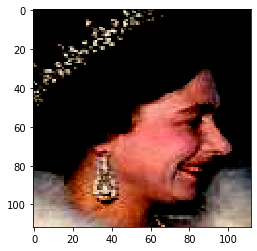

In [48]:
plt.imshow(img)

(112, 112, 3)


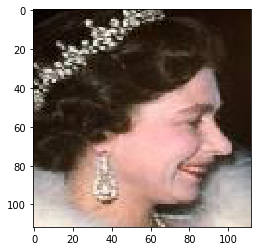

In [128]:
f = '/home/cocoza4/datasets/cfp_profile/391/04.jpg'
img = np.asarray(Image.open(f))
print(img.shape)
# print(np.expand_dims(img, axis=-1).shape)
img = to_rgb(img)
# print(img.shape)
plt.imshow(img)

In [67]:
ret = to_rgb(img)
ret.ndim

3

In [51]:
tf.is_tensor(image)

True

In [96]:
raw = tf.io.read_file(f)
image = tf.image.decode_image(raw)
w, h, c = image.shape
# print(image.shape)
# if c > 3 or c == 1:
#     image = to_rgb(image.numpy())
print(image.shape)
# plt.imshow(image)

(112, 112, 1)


In [132]:
ret = np.empty((w, h, 4), dtype=np.uint8)
ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = ret[:, :, 3] = image.numpy().squeeze()
ret.shape

(112, 112, 4)

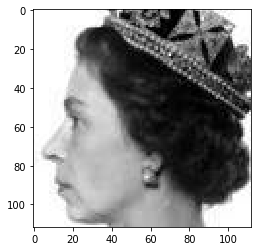

In [133]:
plt.imshow(to_rgb(ret))

In [85]:
a = np.array([[1, 2, 3, 4], [1, 2, 3, 4]], dtype='float')
tf.nn.l2_normalize(a, axis=1)

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[0.18257419, 0.36514837, 0.54772256, 0.73029674],
       [0.18257419, 0.36514837, 0.54772256, 0.73029674]])>

In [88]:
tf.nn.l2_normalize(a, axis=-1)

<tf.Tensor: shape=(2, 4), dtype=float64, numpy=
array([[0.18257419, 0.36514837, 0.54772256, 0.73029674],
       [0.18257419, 0.36514837, 0.54772256, 0.73029674]])>

(112, 112, 3)


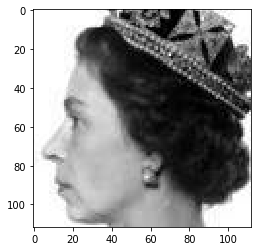

In [34]:
ret = np.empty((w, h, 3), dtype=np.uint8)
print(ret.shape)
ret[:, :, 0] = ret[:, :, 1] = ret[:, :, 2] = image
plt.imshow(ret)

In [93]:
image.squeeze().shape

(112, 112, 3)